<a href="https://colab.research.google.com/github/kalingasajja/left_ventricle_segmentation/blob/main/Left_Ventricle_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [8]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('/content/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('/content/val_images.tfrecords')

In [9]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [10]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)


In [11]:

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [12]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [13]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [14]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [15]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [16]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [17]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

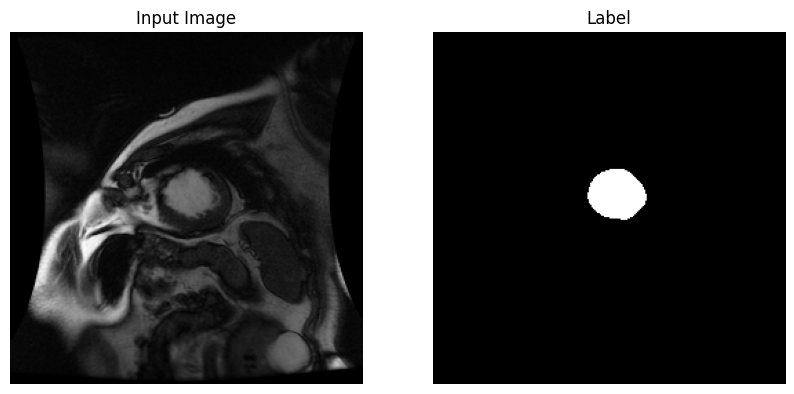

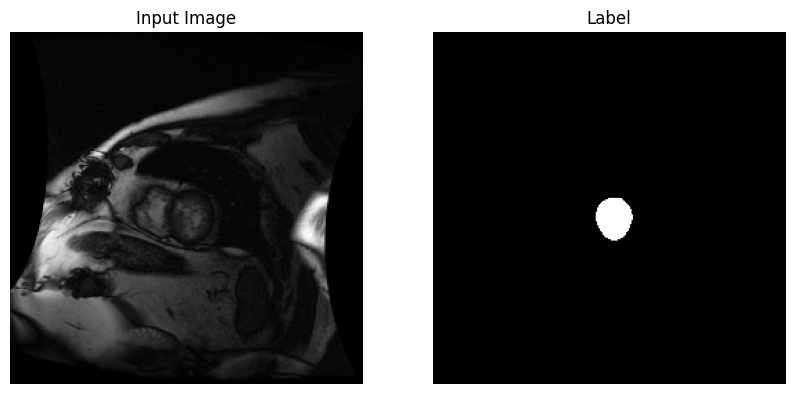

In [18]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

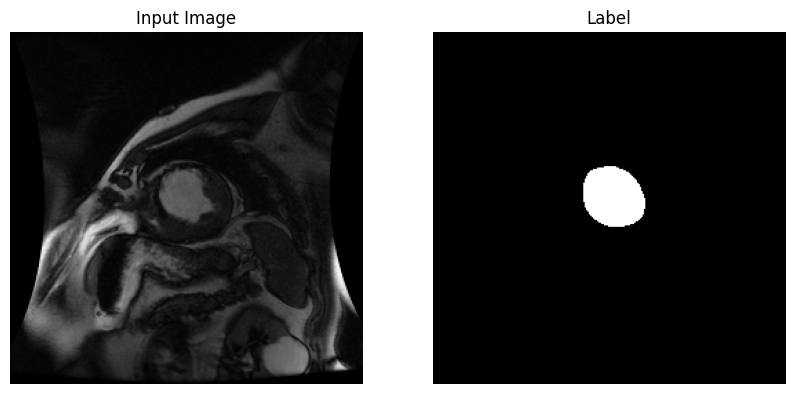

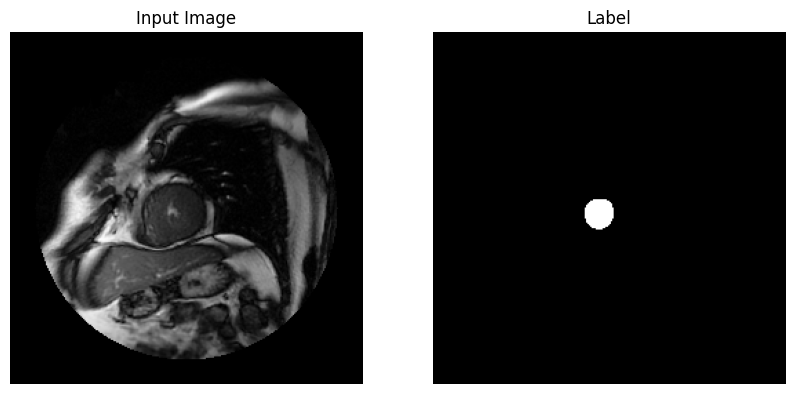

In [19]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [20]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │     8,519,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,714,048 (48.50 MB)

 Trainable params: 12,714,048 (48.50 MB)

 Non-trainable params: 0 (0.00 B)

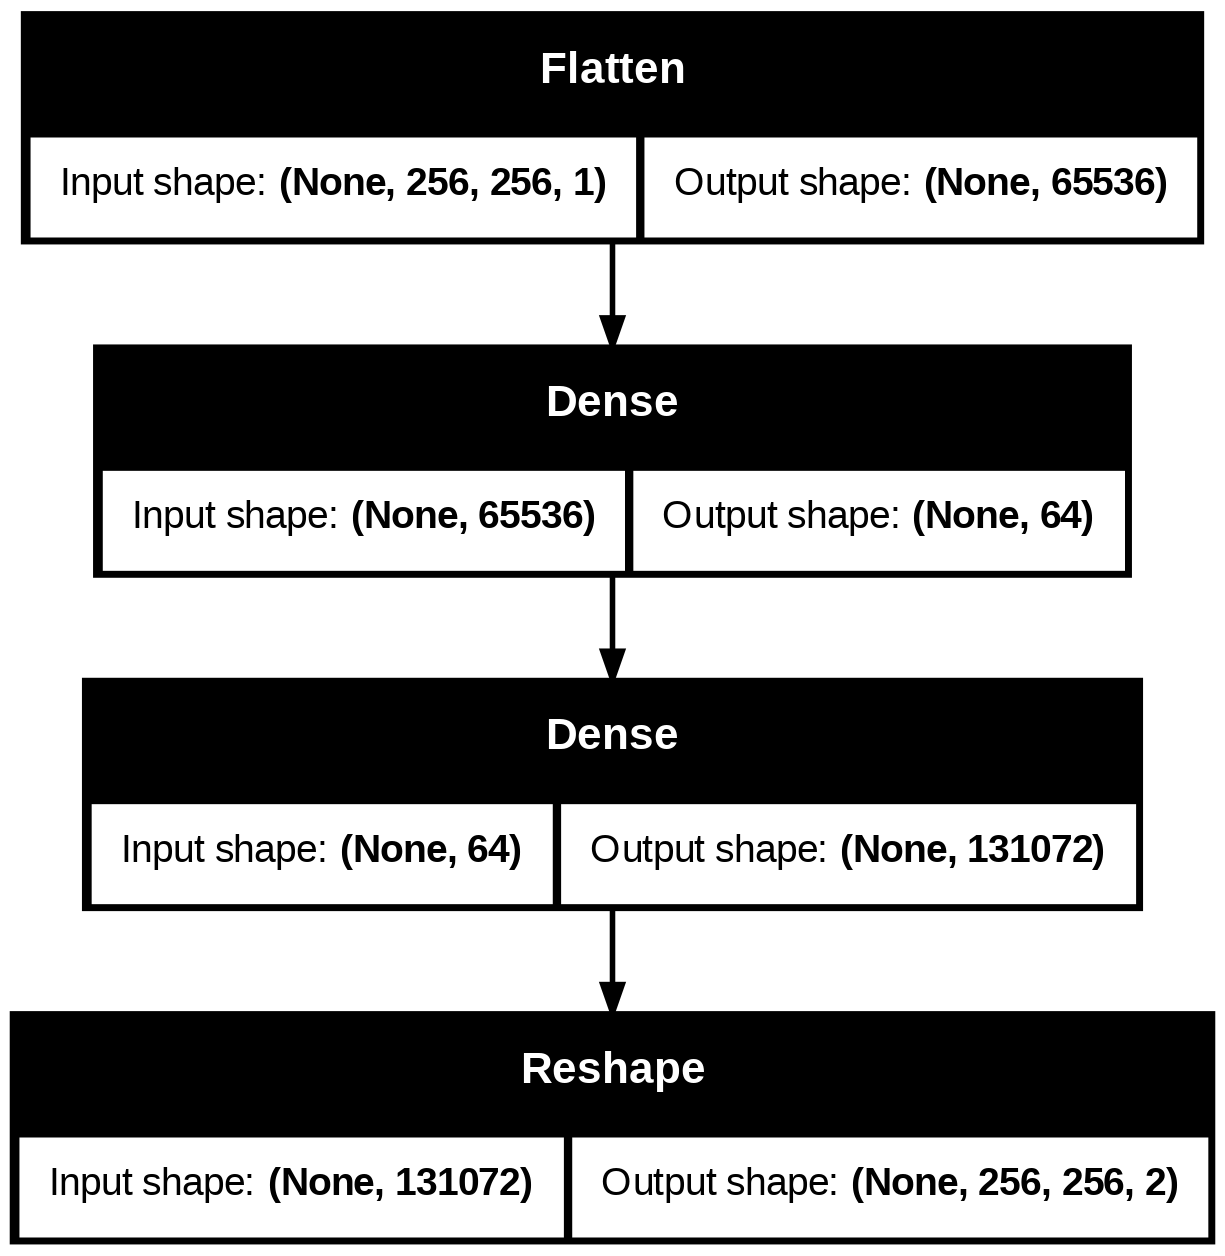

In [22]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


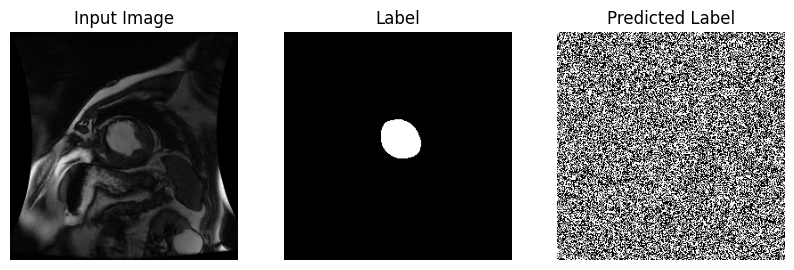

In [25]:
# show a predection, as an example
show_predictions(test_dataset)

In [26]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


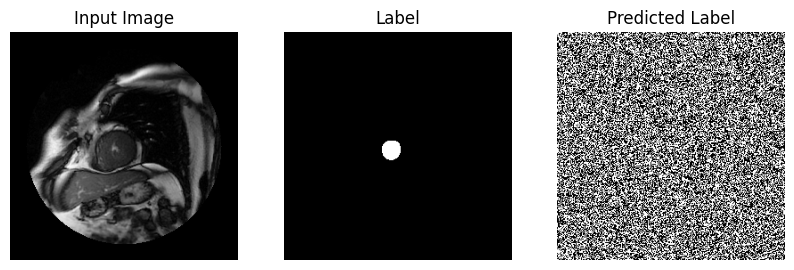


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 181ms/step - accuracy: 0.5007 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


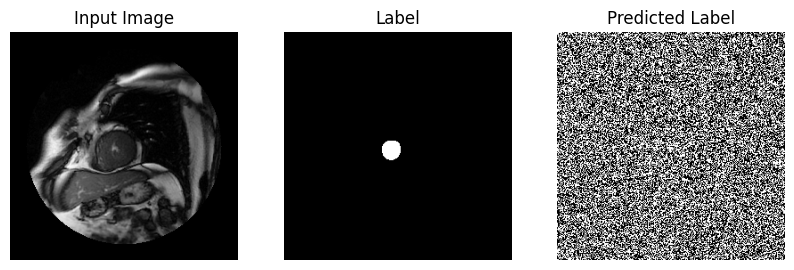


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.5141 - loss: 0.6931 - val_accuracy: 0.5282 - val_loss: 0.6931
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


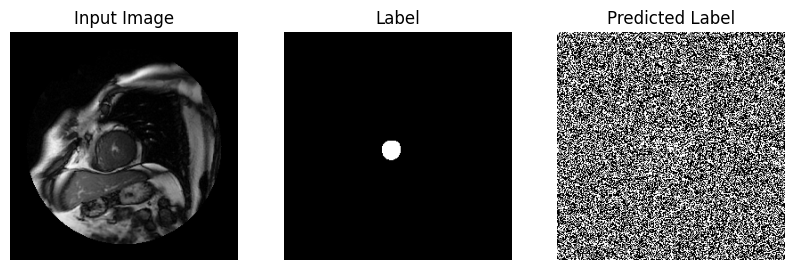


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.5337 - loss: 0.6931 - val_accuracy: 0.5544 - val_loss: 0.6931
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


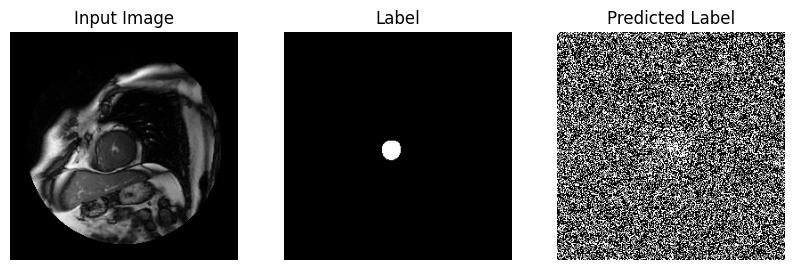


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.5658 - loss: 0.6931 - val_accuracy: 0.6151 - val_loss: 0.6931
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


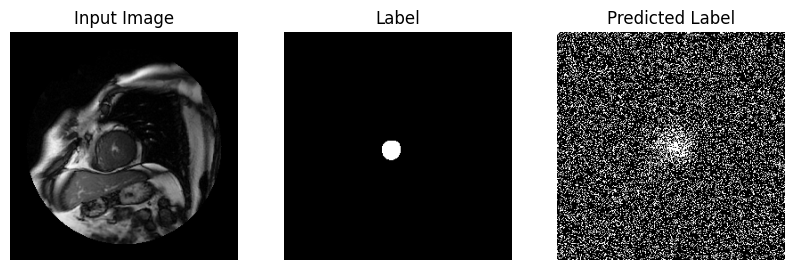


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.6436 - loss: 0.6931 - val_accuracy: 0.7627 - val_loss: 0.6931
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


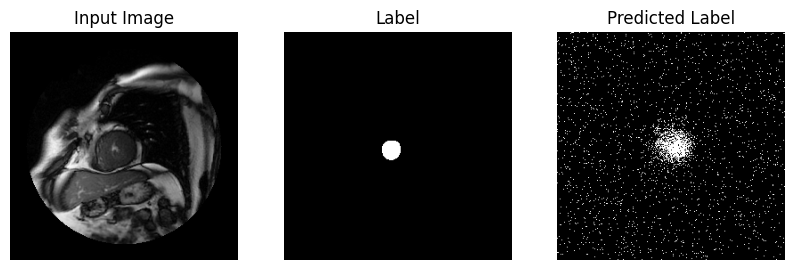


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.8152 - loss: 0.6931 - val_accuracy: 0.9579 - val_loss: 0.6931
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


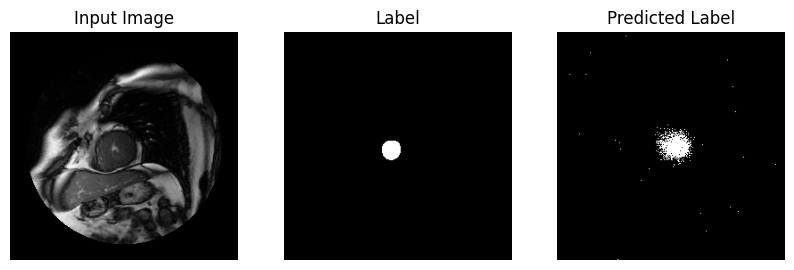


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.9733 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


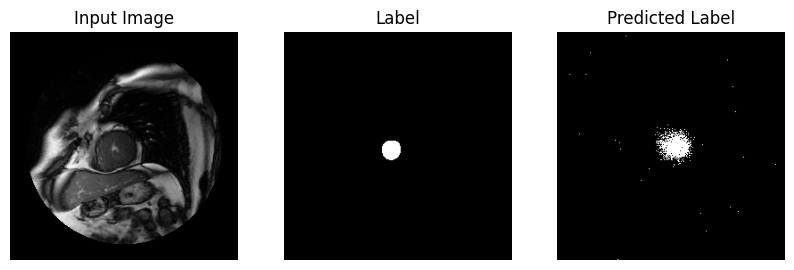


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


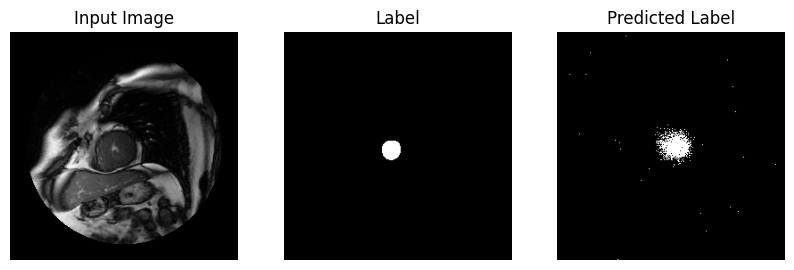


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 81s 348ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


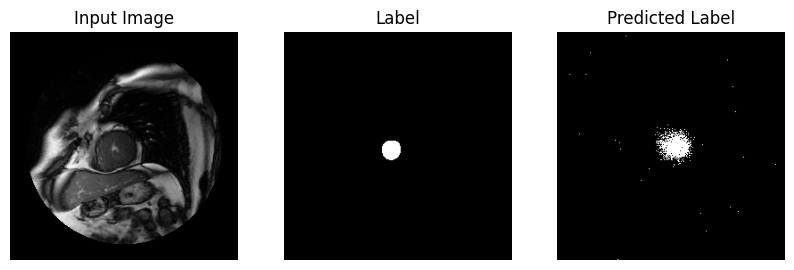


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9869 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


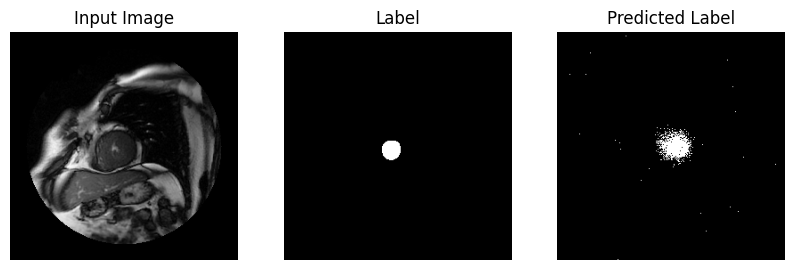


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


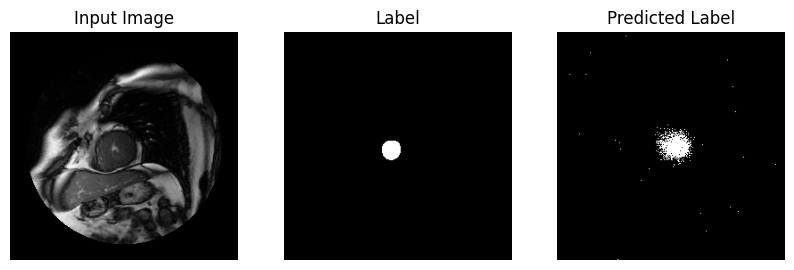


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


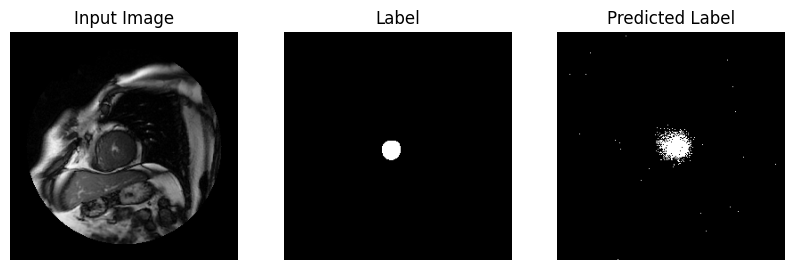


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


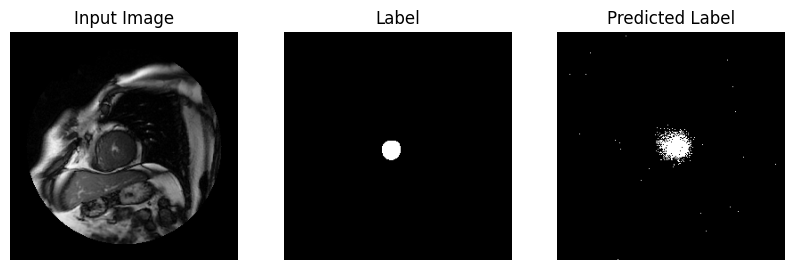


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - accuracy: 0.9872 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


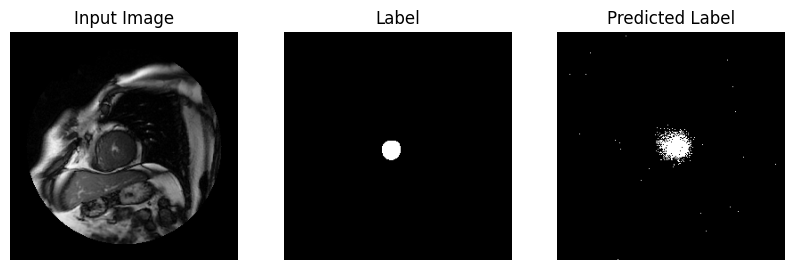


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.9870 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


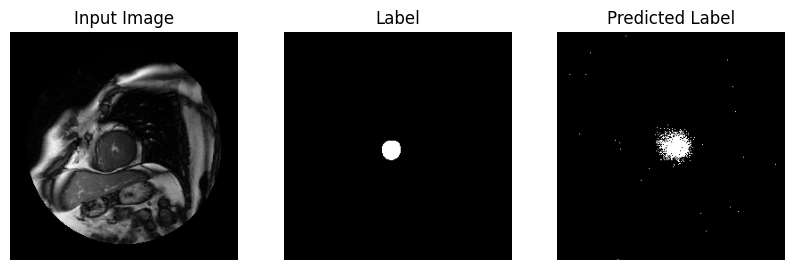


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 83s 355ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


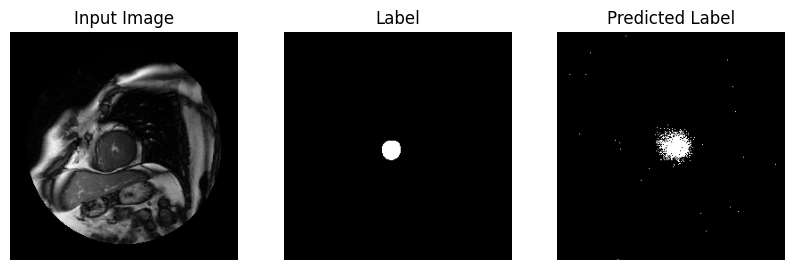


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 81s 347ms/step - accuracy: 0.9870 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


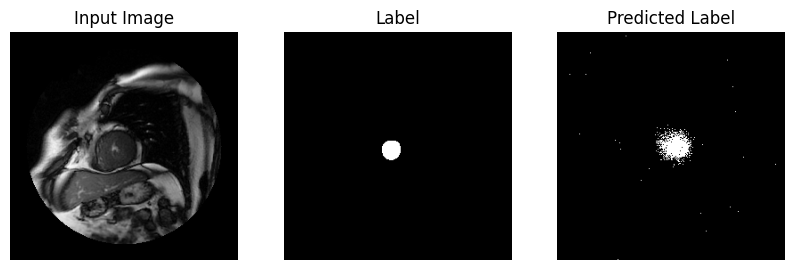


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.9870 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


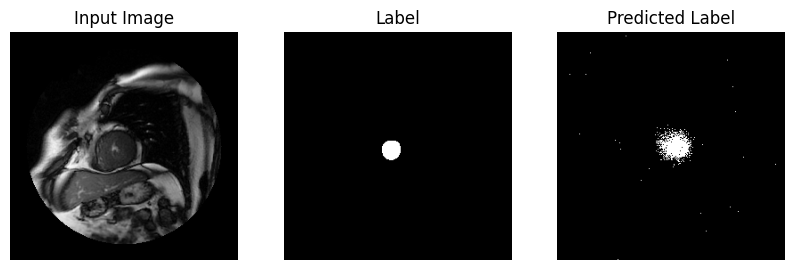


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.9871 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


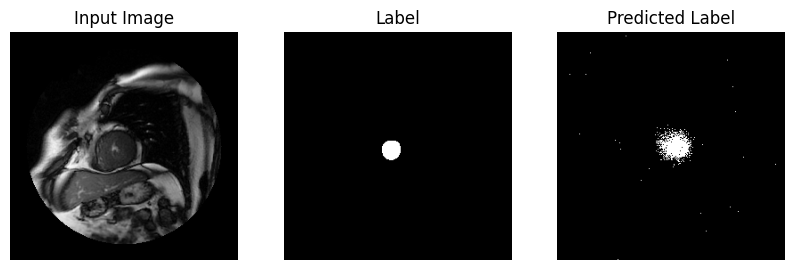


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.9870 - loss: 0.6931 - val_accuracy: 0.9863 - val_loss: 0.6931


In [27]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

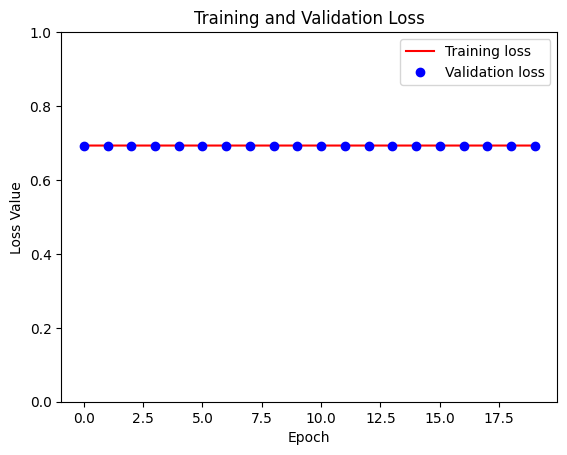

In [28]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [29]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9850 - loss: 0.6931


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.693139374256134, 0.9863316416740417]

In [30]:
%load_ext tensorboard

In [31]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


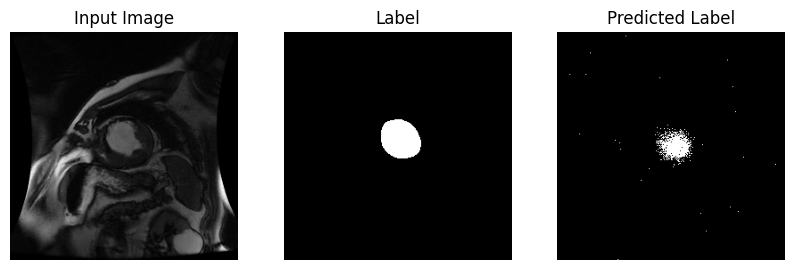

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


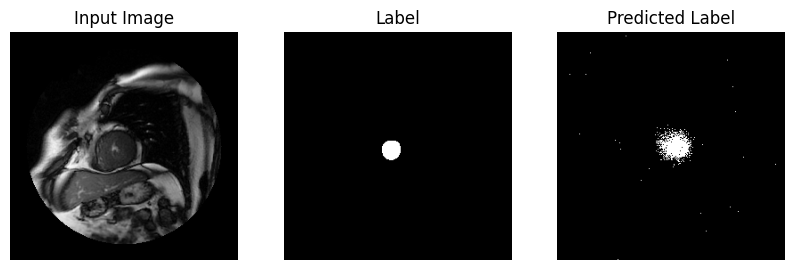

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


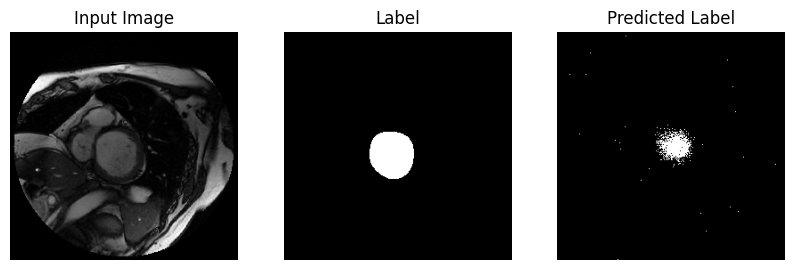

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


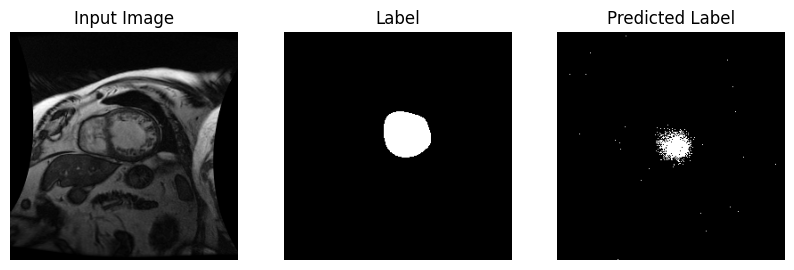

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


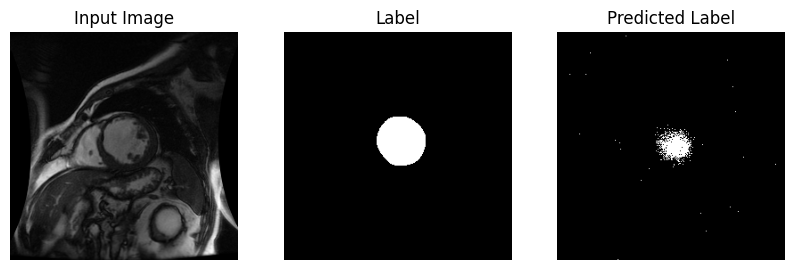

In [32]:
show_predictions(test_dataset, 5)

In [33]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857,848 (7.09 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

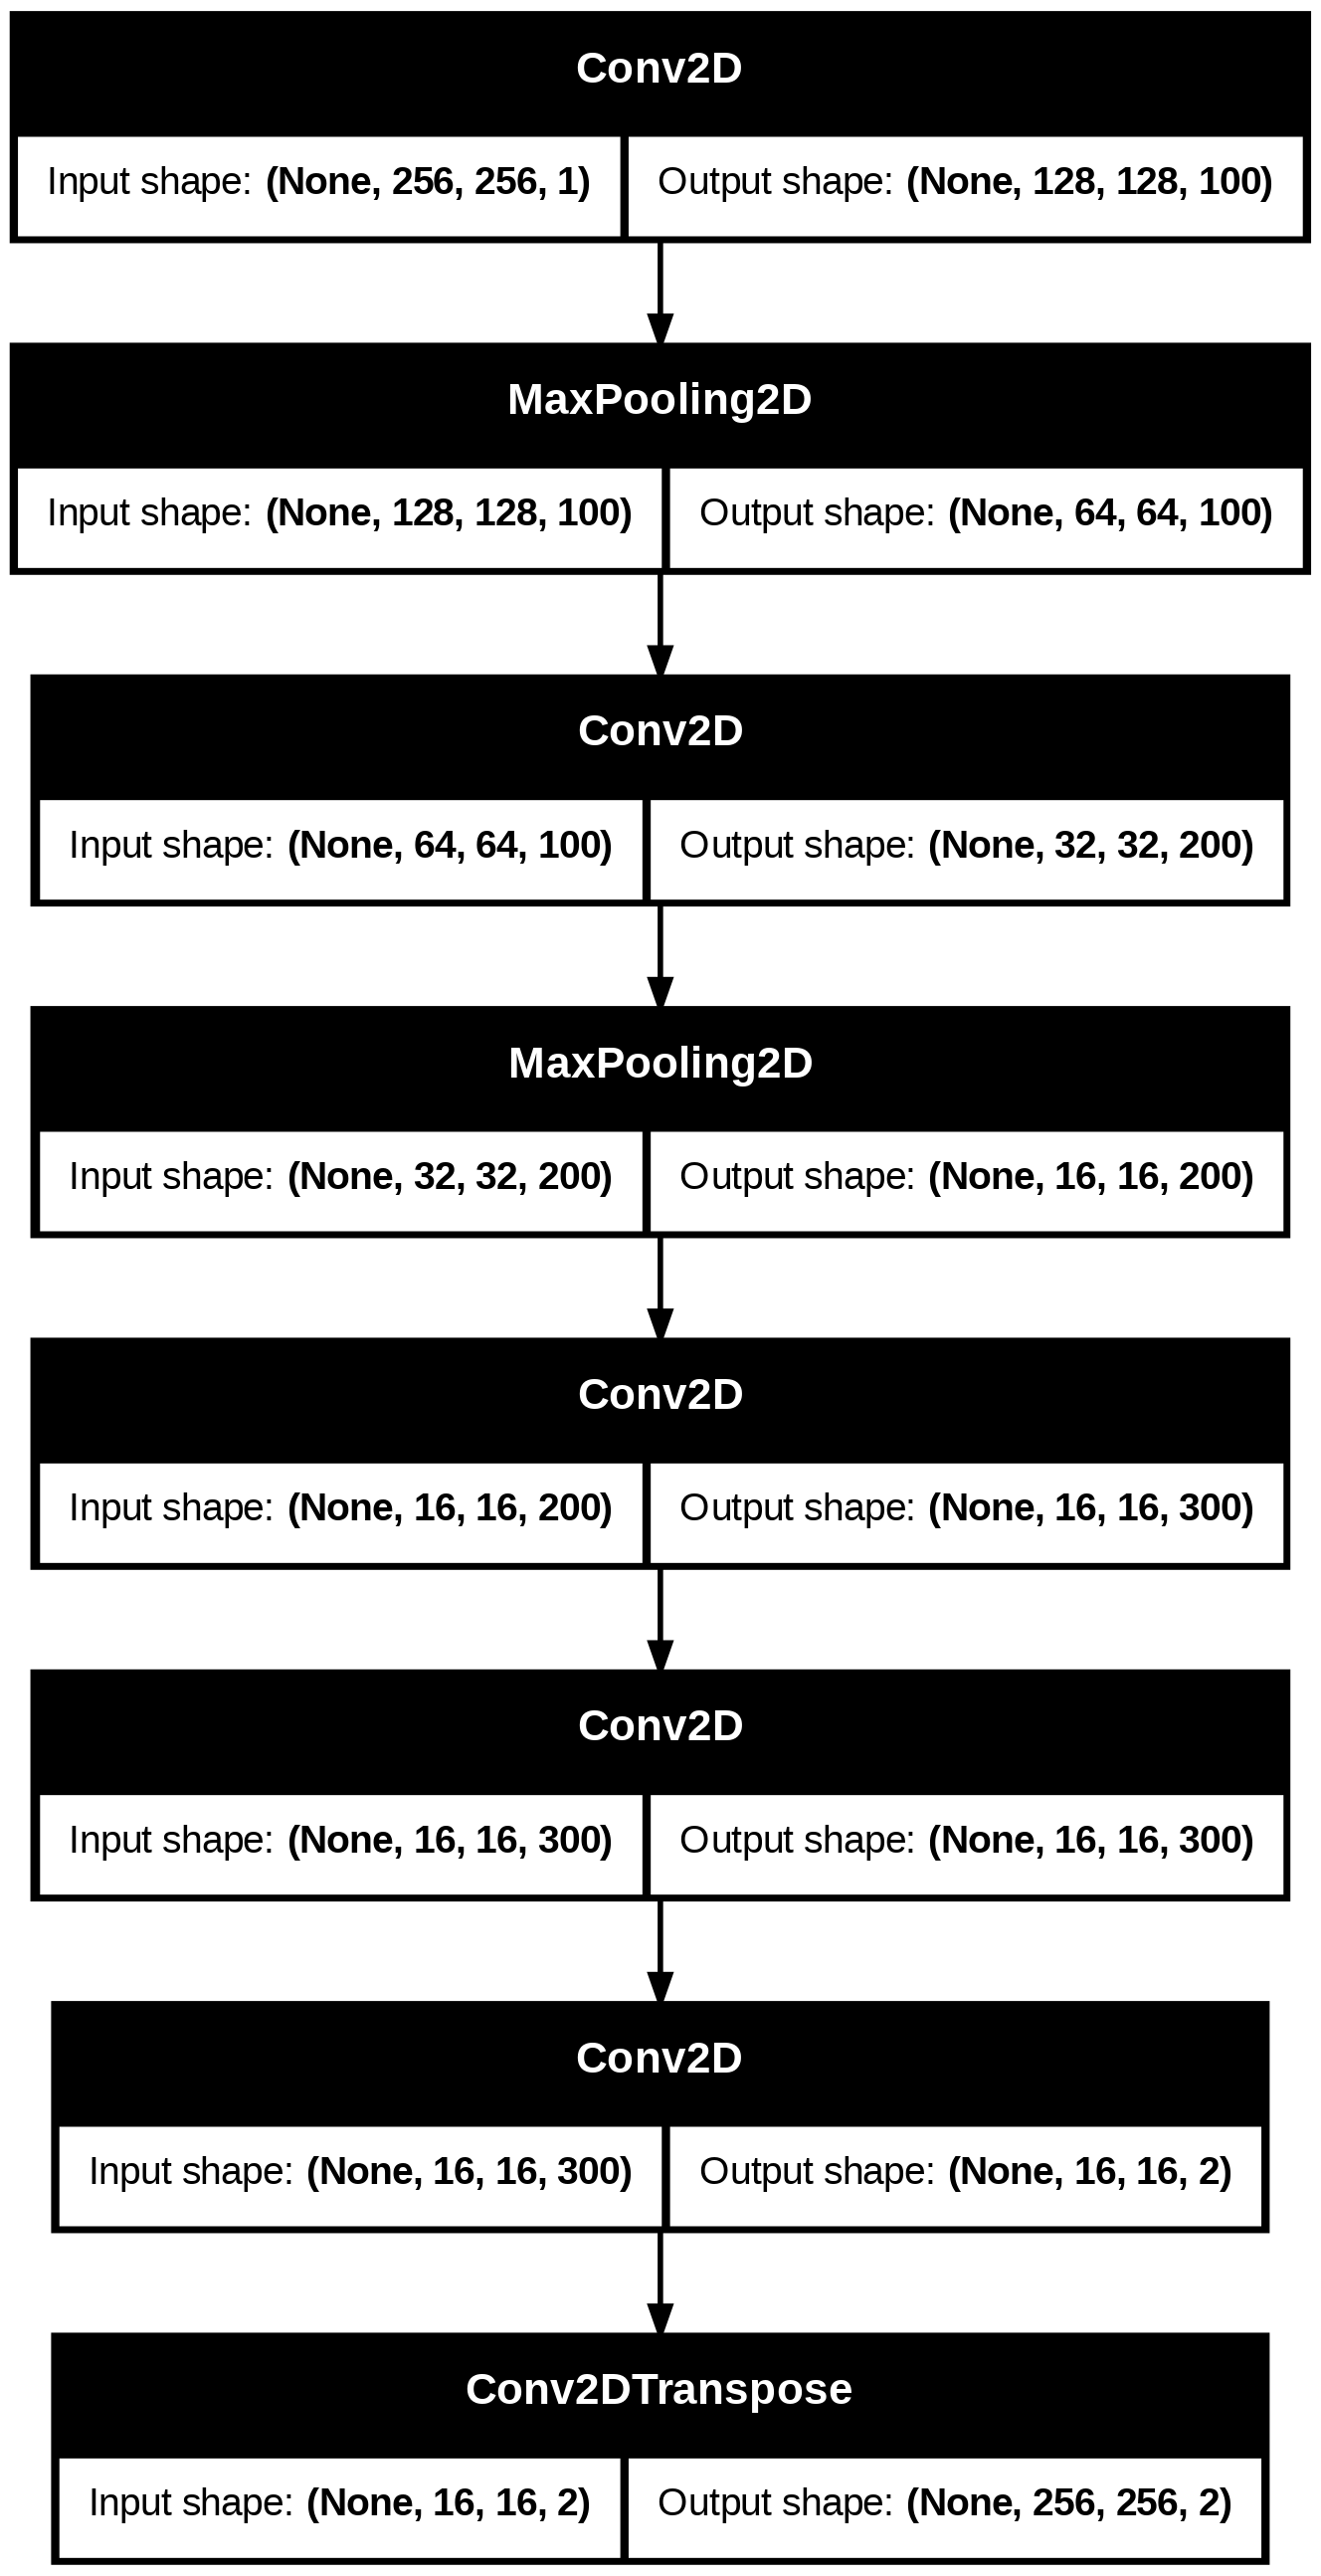

In [35]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


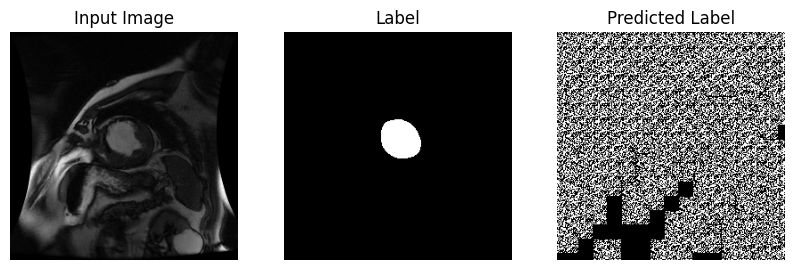

In [36]:
# show a predection, as an example
show_predictions(test_dataset)

In [37]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


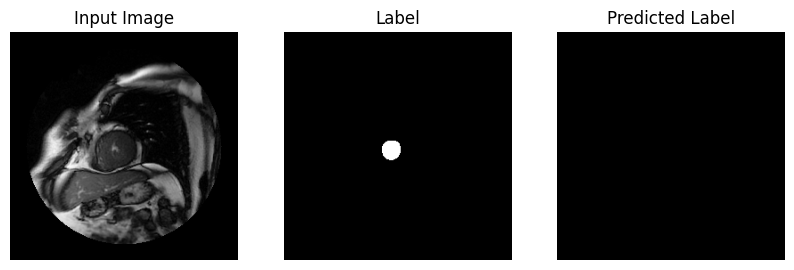


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9357 - loss: 0.1854 - val_accuracy: 0.9830 - val_loss: 0.0464
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


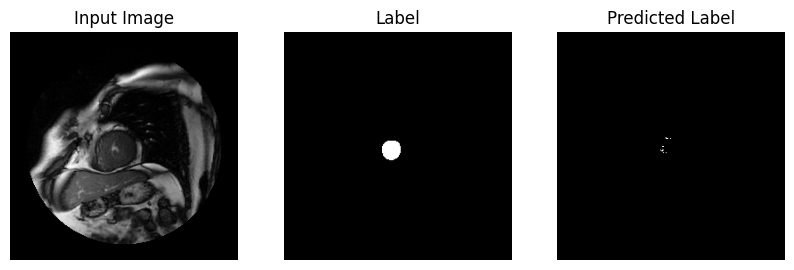


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9847 - loss: 0.0394 - val_accuracy: 0.9832 - val_loss: 0.0324
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


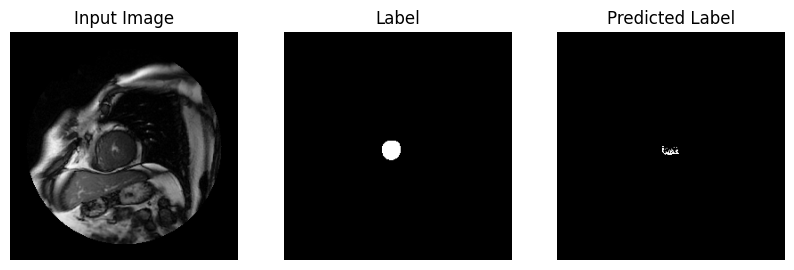


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.9851 - loss: 0.0287 - val_accuracy: 0.9878 - val_loss: 0.0251
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


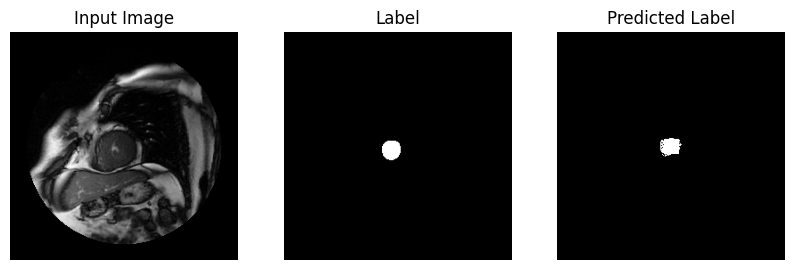


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9896 - loss: 0.0224 - val_accuracy: 0.9897 - val_loss: 0.0238
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


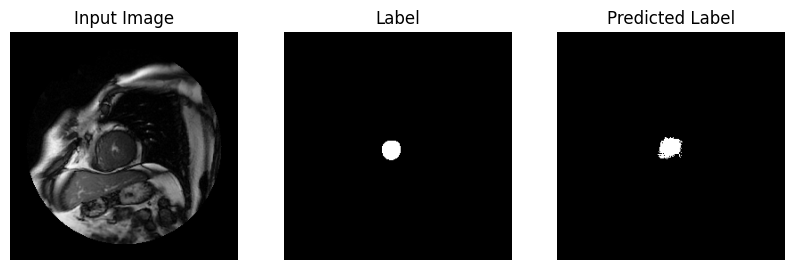


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9916 - loss: 0.0195 - val_accuracy: 0.9917 - val_loss: 0.0212
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


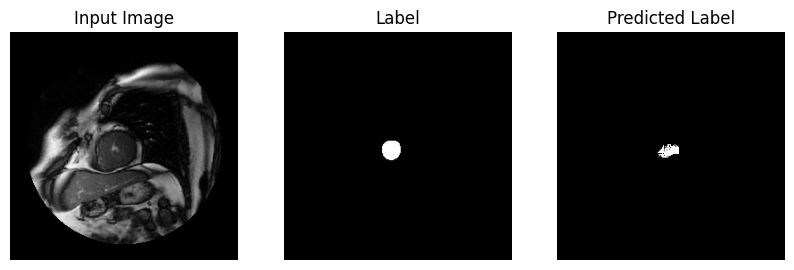


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9932 - loss: 0.0171 - val_accuracy: 0.9916 - val_loss: 0.0209
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


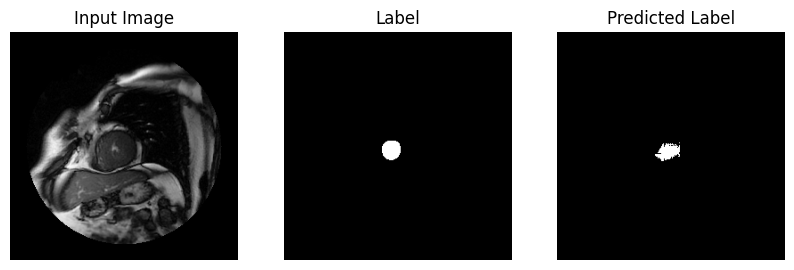


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9944 - loss: 0.0147 - val_accuracy: 0.9937 - val_loss: 0.0173
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


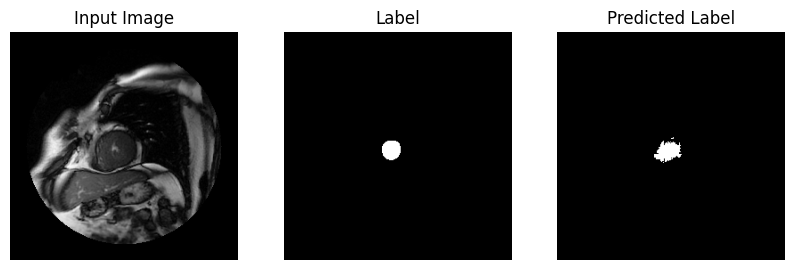


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.9953 - loss: 0.0132 - val_accuracy: 0.9943 - val_loss: 0.0159
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


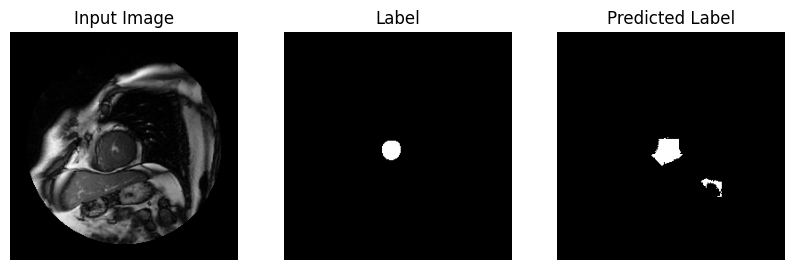


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.9956 - loss: 0.0121 - val_accuracy: 0.9938 - val_loss: 0.0171
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


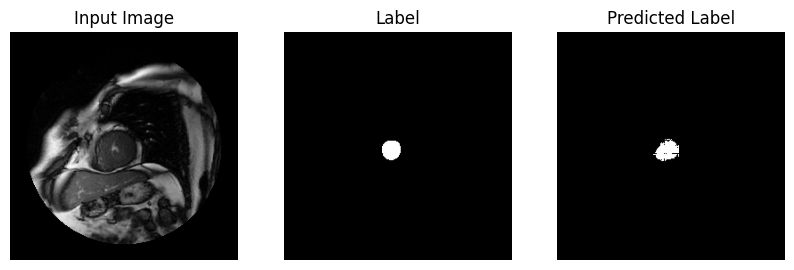


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9929 - loss: 0.0202 - val_accuracy: 0.9948 - val_loss: 0.0139
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


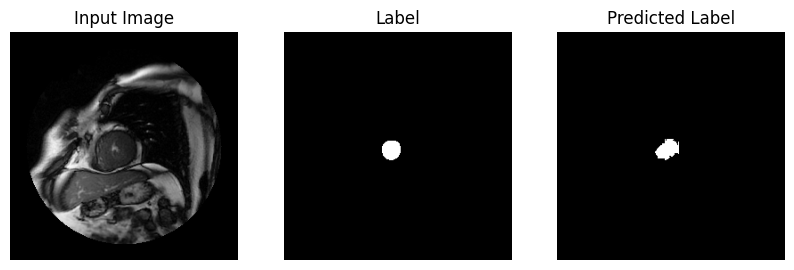


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9960 - loss: 0.0098 - val_accuracy: 0.9954 - val_loss: 0.0126
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


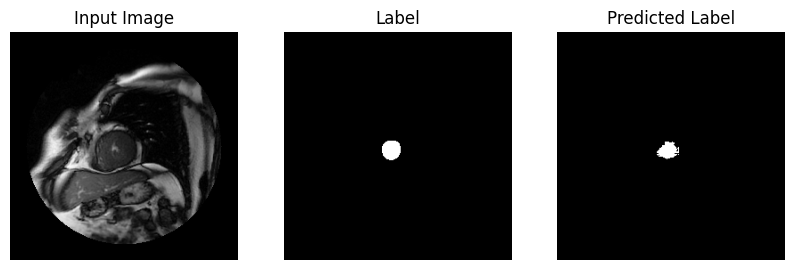


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9967 - loss: 0.0080 - val_accuracy: 0.9955 - val_loss: 0.0124
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


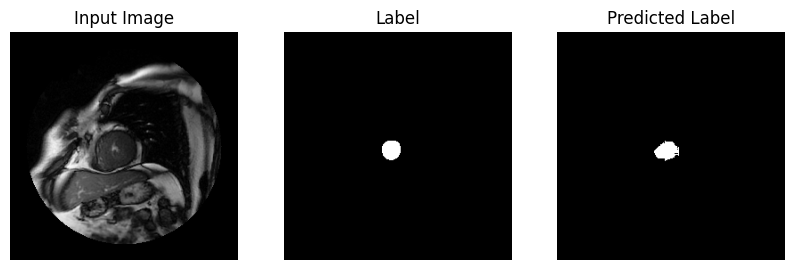


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.9971 - loss: 0.0070 - val_accuracy: 0.9962 - val_loss: 0.0100
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


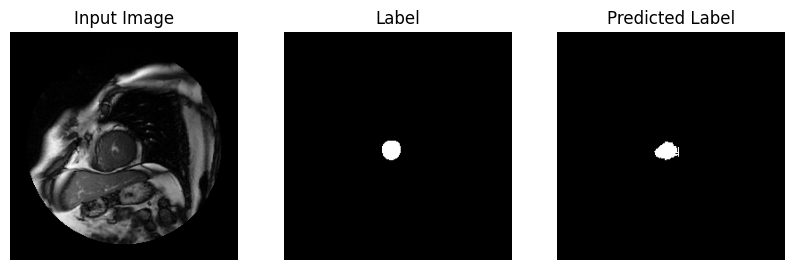


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9974 - loss: 0.0064 - val_accuracy: 0.9965 - val_loss: 0.0094
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


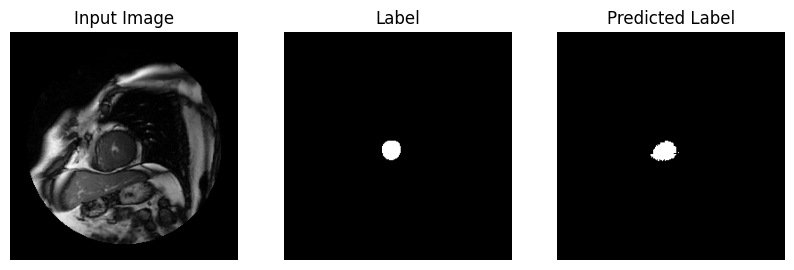


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.9965 - val_loss: 0.0092
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


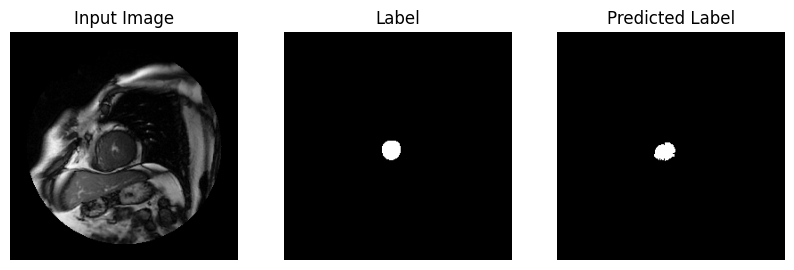


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.9978 - loss: 0.0052 - val_accuracy: 0.9969 - val_loss: 0.0084
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


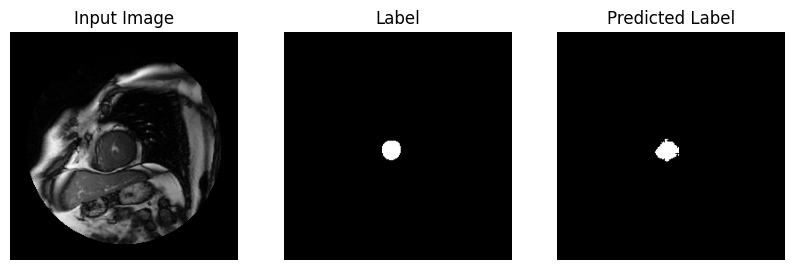


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9979 - loss: 0.0051 - val_accuracy: 0.9963 - val_loss: 0.0113
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


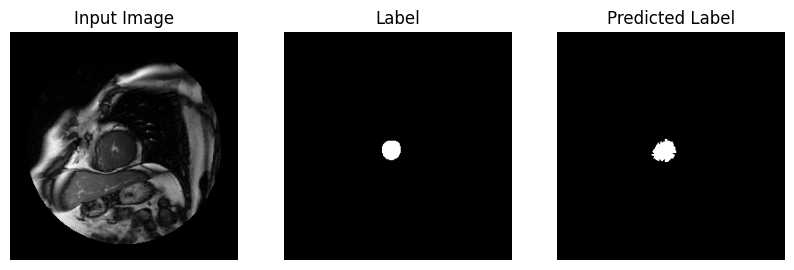


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9980 - loss: 0.0047 - val_accuracy: 0.9967 - val_loss: 0.0085
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


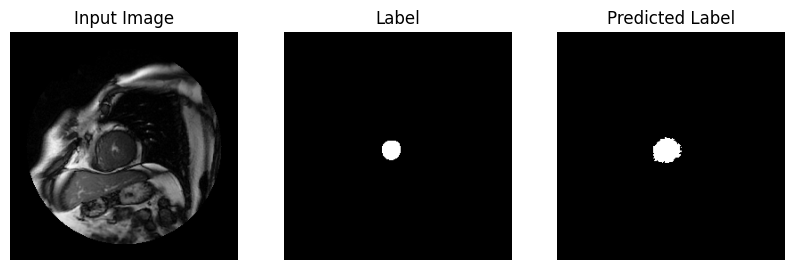


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9982 - loss: 0.0042 - val_accuracy: 0.9964 - val_loss: 0.0100
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


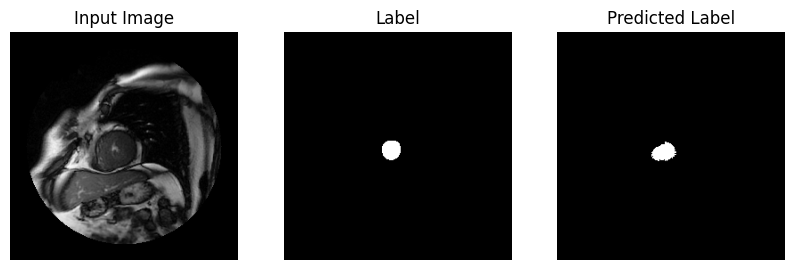


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9980 - loss: 0.0047 - val_accuracy: 0.9971 - val_loss: 0.0078


In [38]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

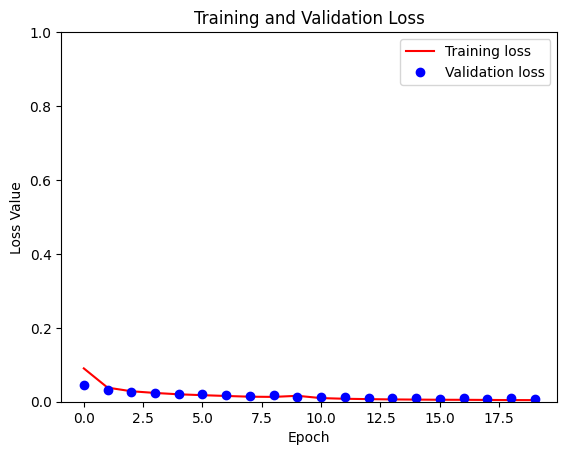

In [39]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [40]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9972 - loss: 0.0073


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.007780891377478838, 0.9970697164535522]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


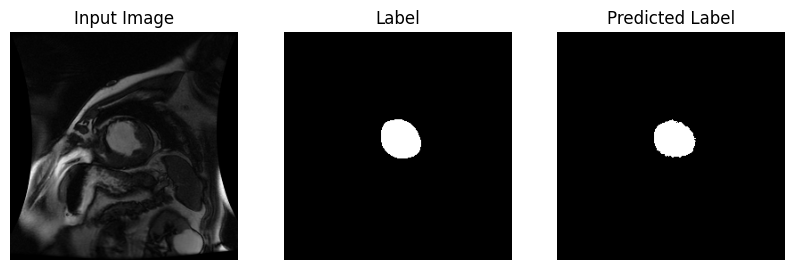

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


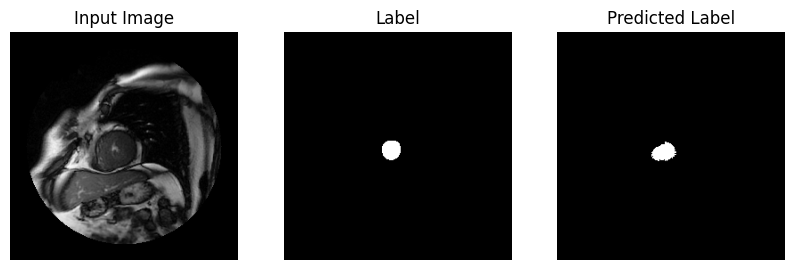

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


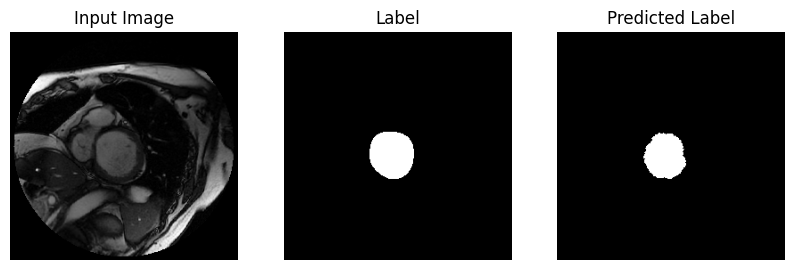

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


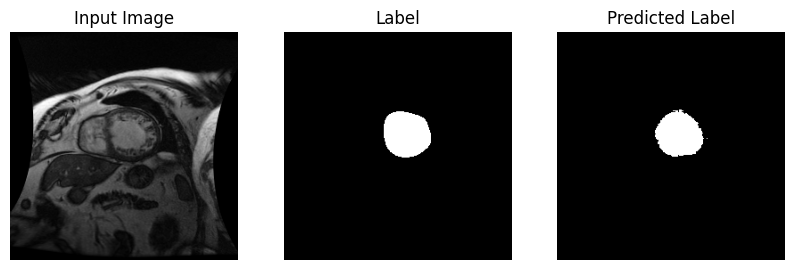

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


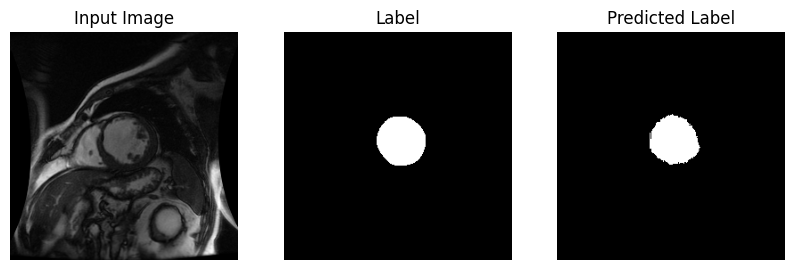

In [41]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [44]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    # Cast y_true to float32 to match the type of indices_cast
    true_cast = K.cast(y_true, dtype='float32')
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [45]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [46]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Inspecting the output of read_and_decode...
Example 0:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 1:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 2:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 3:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 4:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 5:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 6:
  Image shape: (256, 256, 1), Image dtype: <dtype: 'float32'>
  Label shape: (256, 256, 1), Label dtype: <dtype: 'uint8'>
Example 7:
  Image shape:

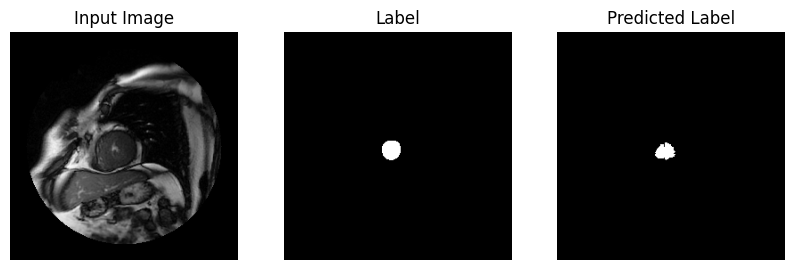


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.9981 - dice_coef: 0.9041 - loss: 0.0046 - val_accuracy: 0.9968 - val_dice_coef: 0.8190 - val_loss: 0.0091
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


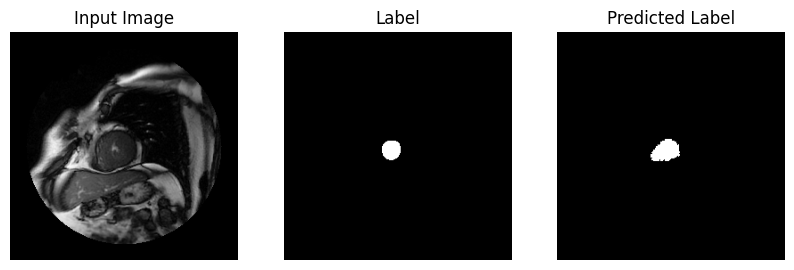


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9981 - dice_coef: 0.8988 - loss: 0.0046 - val_accuracy: 0.9967 - val_dice_coef: 0.8439 - val_loss: 0.0089
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


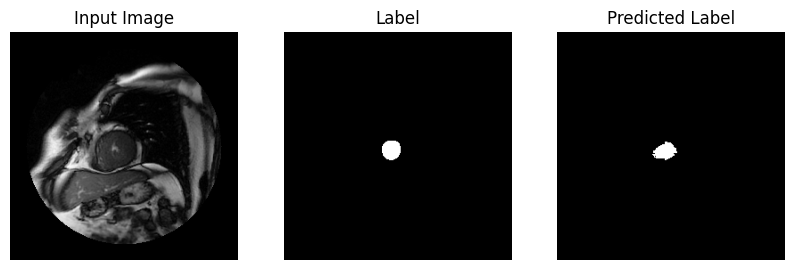


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - accuracy: 0.9983 - dice_coef: 0.9169 - loss: 0.0040 - val_accuracy: 0.9972 - val_dice_coef: 0.8346 - val_loss: 0.0081
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


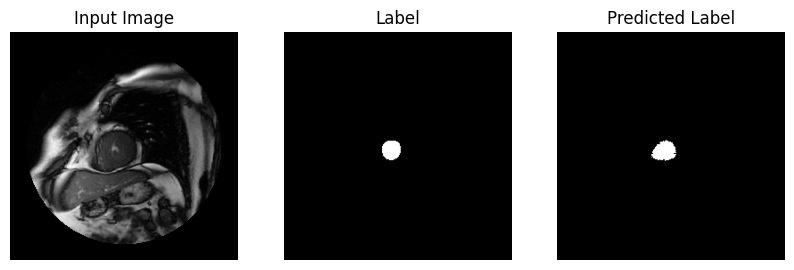


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9984 - dice_coef: 0.9191 - loss: 0.0037 - val_accuracy: 0.9972 - val_dice_coef: 0.8312 - val_loss: 0.0079
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


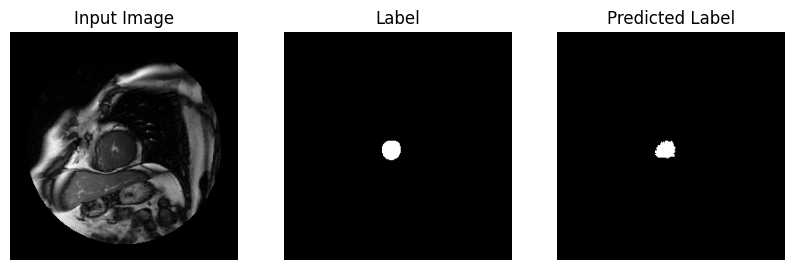


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9983 - dice_coef: 0.9154 - loss: 0.0041 - val_accuracy: 0.9973 - val_dice_coef: 0.8362 - val_loss: 0.0079
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


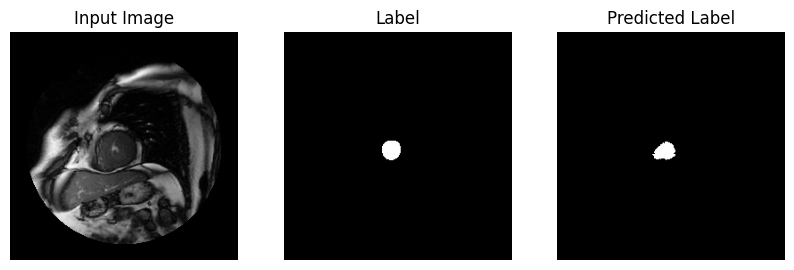


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.9986 - dice_coef: 0.9289 - loss: 0.0033 - val_accuracy: 0.9972 - val_dice_coef: 0.8354 - val_loss: 0.0084
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


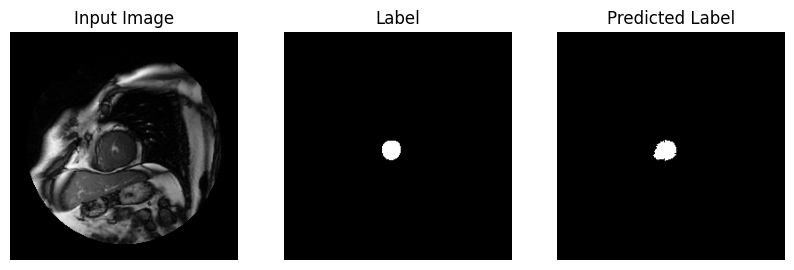


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9986 - dice_coef: 0.9270 - loss: 0.0032 - val_accuracy: 0.9973 - val_dice_coef: 0.8476 - val_loss: 0.0078
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


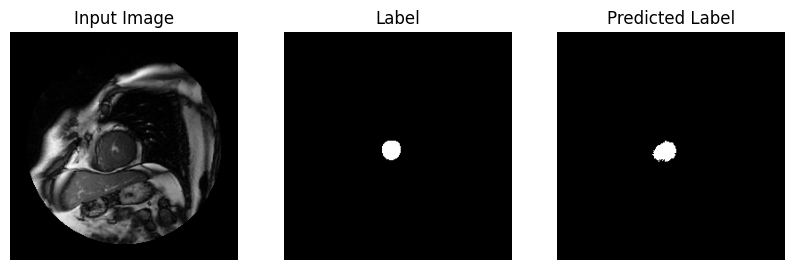


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.9987 - dice_coef: 0.9348 - loss: 0.0029 - val_accuracy: 0.9972 - val_dice_coef: 0.8386 - val_loss: 0.0088
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


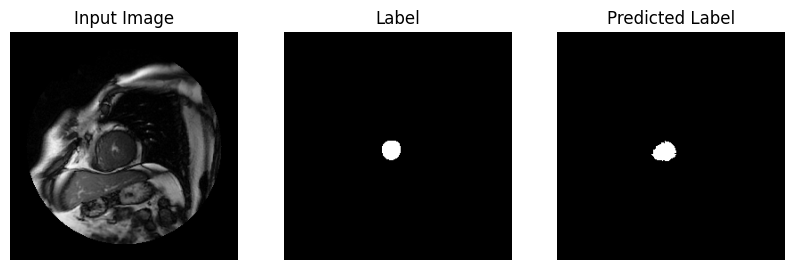


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.9983 - dice_coef: 0.9157 - loss: 0.0040 - val_accuracy: 0.9973 - val_dice_coef: 0.8483 - val_loss: 0.0081
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


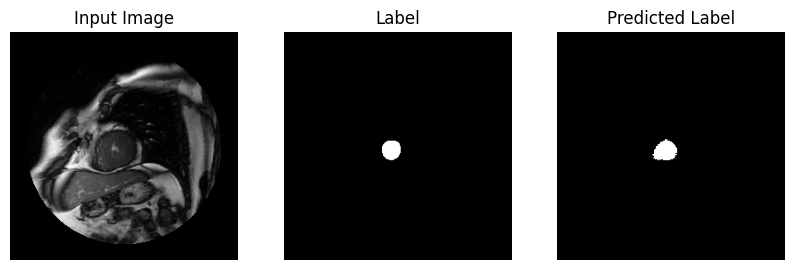


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9986 - dice_coef: 0.9241 - loss: 0.0034 - val_accuracy: 0.9973 - val_dice_coef: 0.8417 - val_loss: 0.0087
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


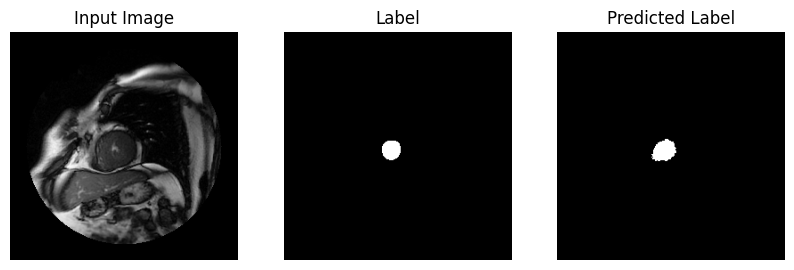


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.9988 - dice_coef: 0.9421 - loss: 0.0027 - val_accuracy: 0.9971 - val_dice_coef: 0.8530 - val_loss: 0.0092
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


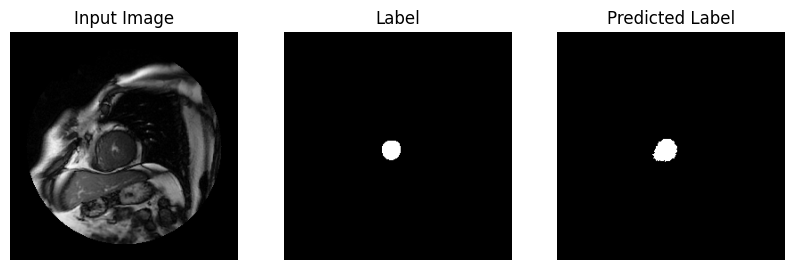


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9988 - dice_coef: 0.9404 - loss: 0.0027 - val_accuracy: 0.9972 - val_dice_coef: 0.8590 - val_loss: 0.0088
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


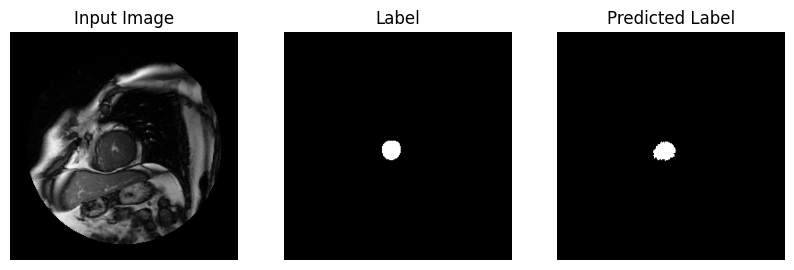


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - accuracy: 0.9988 - dice_coef: 0.9338 - loss: 0.0028 - val_accuracy: 0.9972 - val_dice_coef: 0.8429 - val_loss: 0.0082
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


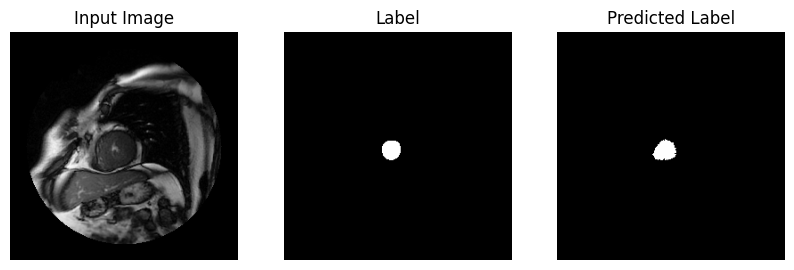


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9987 - dice_coef: 0.9341 - loss: 0.0029 - val_accuracy: 0.9972 - val_dice_coef: 0.8537 - val_loss: 0.0094
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


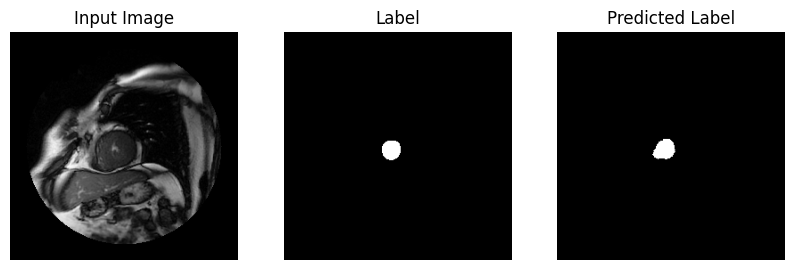


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9987 - dice_coef: 0.9373 - loss: 0.0030 - val_accuracy: 0.9971 - val_dice_coef: 0.8405 - val_loss: 0.0104
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


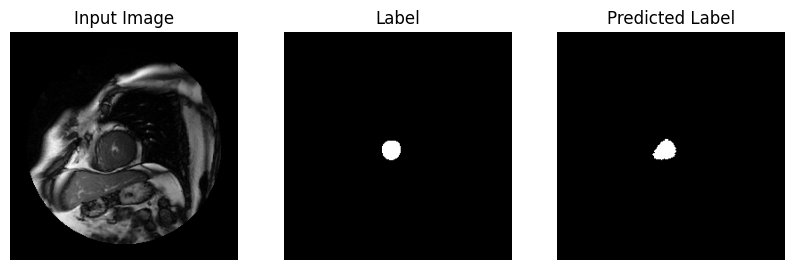


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9988 - dice_coef: 0.9328 - loss: 0.0029 - val_accuracy: 0.9973 - val_dice_coef: 0.8386 - val_loss: 0.0091
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


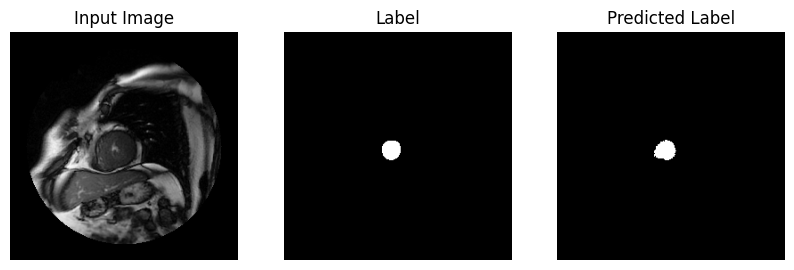


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.9988 - dice_coef: 0.9417 - loss: 0.0027 - val_accuracy: 0.9973 - val_dice_coef: 0.8362 - val_loss: 0.0101
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


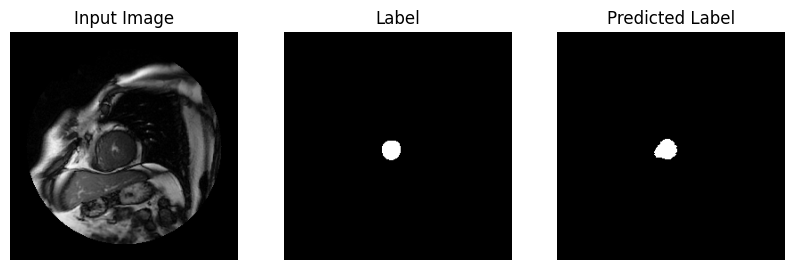


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.9990 - dice_coef: 0.9409 - loss: 0.0024 - val_accuracy: 0.9972 - val_dice_coef: 0.8396 - val_loss: 0.0103
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


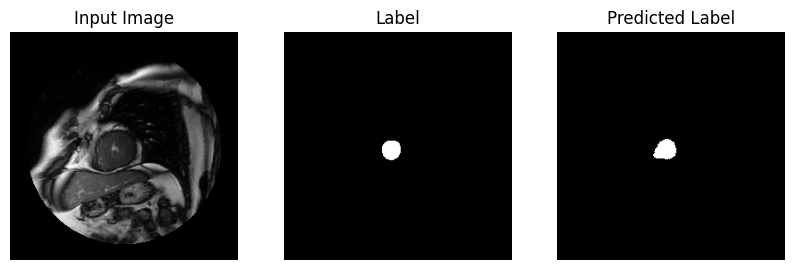


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9989 - dice_coef: 0.9446 - loss: 0.0026 - val_accuracy: 0.9973 - val_dice_coef: 0.8433 - val_loss: 0.0101
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


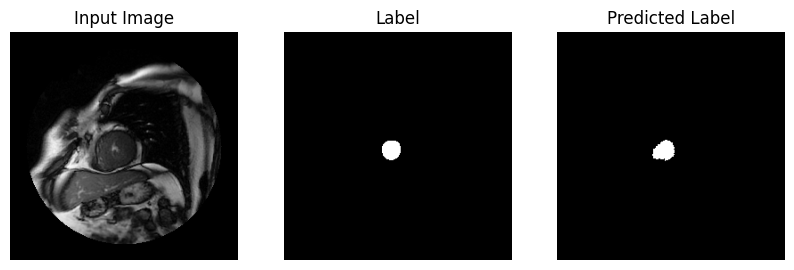


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.9990 - dice_coef: 0.9428 - loss: 0.0024 - val_accuracy: 0.9973 - val_dice_coef: 0.8381 - val_loss: 0.0099
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


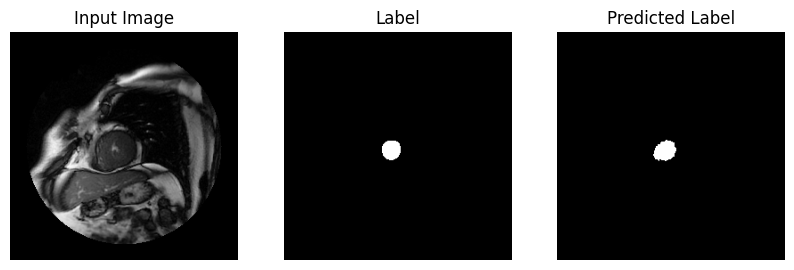


Sample Prediction after epoch 21

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.9989 - dice_coef: 0.9456 - loss: 0.0025 - val_accuracy: 0.9974 - val_dice_coef: 0.8394 - val_loss: 0.0090
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


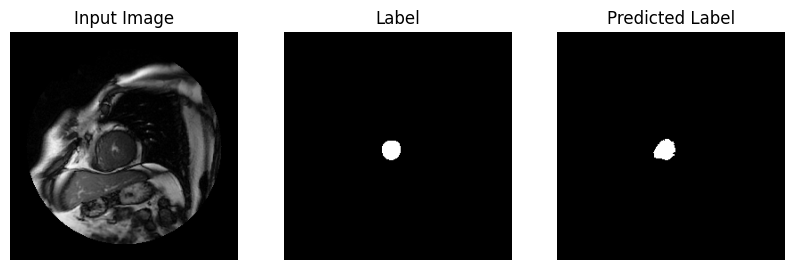


Sample Prediction after epoch 22

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9990 - dice_coef: 0.9415 - loss: 0.0024 - val_accuracy: 0.9974 - val_dice_coef: 0.8463 - val_loss: 0.0097
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


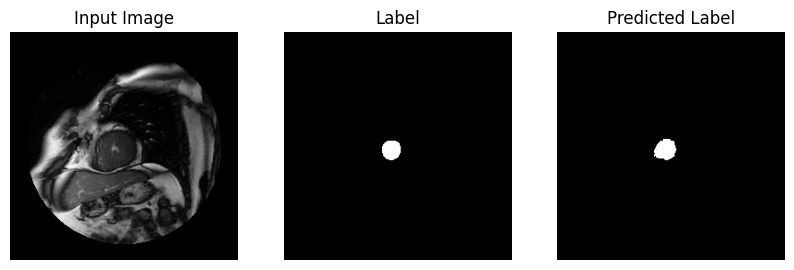


Sample Prediction after epoch 23

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9990 - dice_coef: 0.9502 - loss: 0.0023 - val_accuracy: 0.9971 - val_dice_coef: 0.8400 - val_loss: 0.0110
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


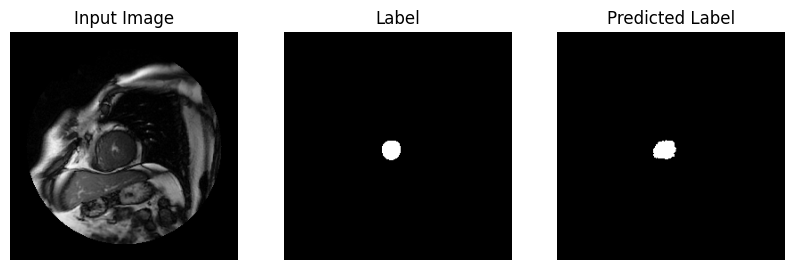


Sample Prediction after epoch 24

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9990 - dice_coef: 0.9482 - loss: 0.0024 - val_accuracy: 0.9974 - val_dice_coef: 0.8456 - val_loss: 0.0087
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


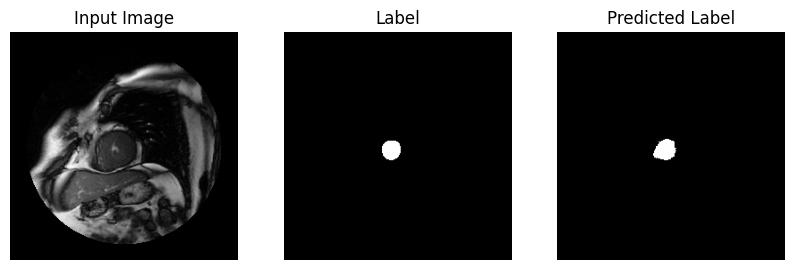


Sample Prediction after epoch 25

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.9990 - dice_coef: 0.9498 - loss: 0.0024 - val_accuracy: 0.9972 - val_dice_coef: 0.8407 - val_loss: 0.0104
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


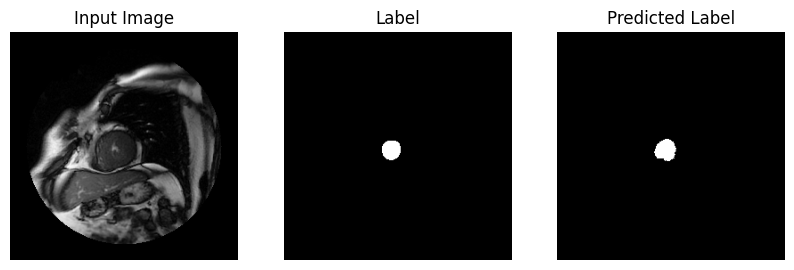


Sample Prediction after epoch 26

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.9990 - dice_coef: 0.9439 - loss: 0.0025 - val_accuracy: 0.9973 - val_dice_coef: 0.8415 - val_loss: 0.0092
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


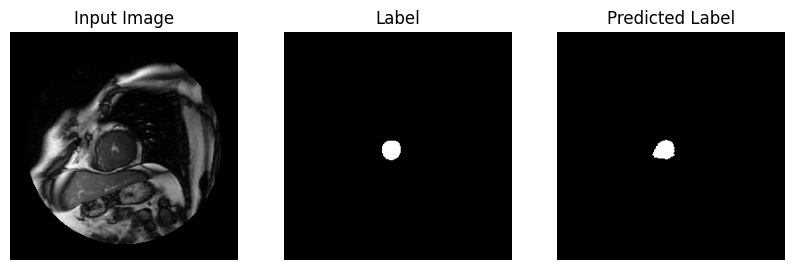


Sample Prediction after epoch 27

234/234 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.9990 - dice_coef: 0.9446 - loss: 0.0023 - val_accuracy: 0.9974 - val_dice_coef: 0.8443 - val_loss: 0.0102
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


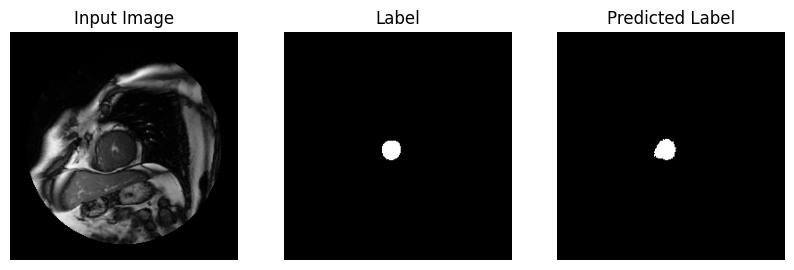


Sample Prediction after epoch 28

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9990 - dice_coef: 0.9462 - loss: 0.0024 - val_accuracy: 0.9974 - val_dice_coef: 0.8694 - val_loss: 0.0092
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


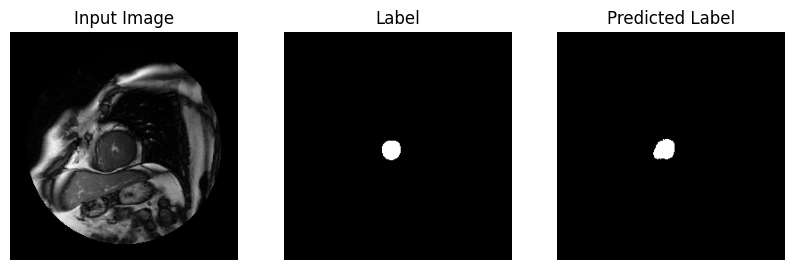


Sample Prediction after epoch 29

234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9991 - dice_coef: 0.9533 - loss: 0.0021 - val_accuracy: 0.9973 - val_dice_coef: 0.8502 - val_loss: 0.0104
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


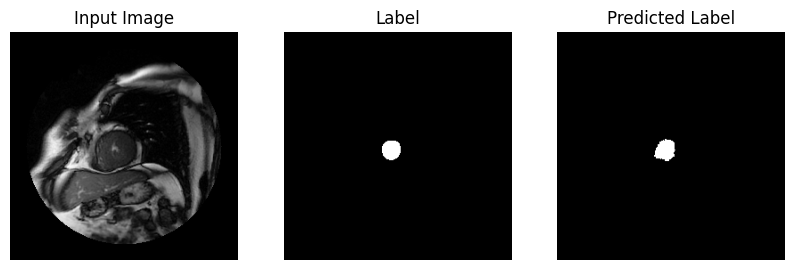


Sample Prediction after epoch 30

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9991 - dice_coef: 0.9499 - loss: 0.0020 - val_accuracy: 0.9973 - val_dice_coef: 0.8629 - val_loss: 0.0098


In [47]:
# Inspect the output of the read_and_decode function
print("Inspecting the output of read_and_decode...")
for i, (image, label) in enumerate(train.take(10)):  # Take the first 10 elements
    print(f"Example {i}:")
    print(f"  Image shape: {image.shape}, Image dtype: {image.dtype}")
    print(f"  Label shape: {label.shape}, Label dtype: {label.dtype}")
    # You can add more checks here, e.g., check for unexpected values or empty tensors
    if tf.size(image) == 0 or tf.size(label) == 0:
        print(f"  Warning: Found an empty image or label in example {i}")

print("Inspection complete.")

# Keep the rest of your code for training
# setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

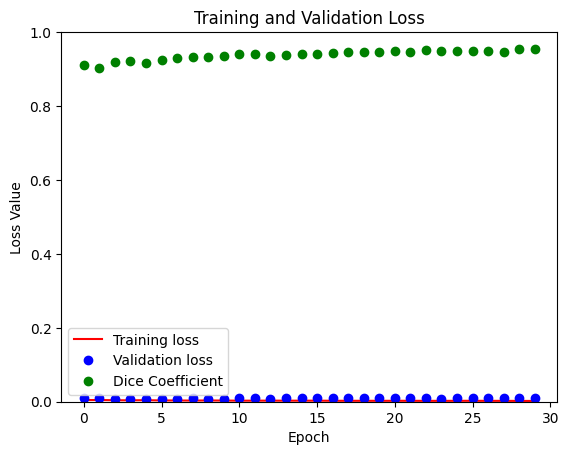

In [48]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [50]:
model.save('my_model.h5')

In [51]:
from google.colab import files
files.download('my_model.h5')  # Downloads to your local system


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>